In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

DATA_DIR = '/content/gdrive/MyDrive/GANs_Dataset'

print(os.listdir(DATA_DIR))


['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['01507.png', '01486.png', '01493.png', '01485.png', '01489.png', '01505.png', '01518.png', '01506.png', '01514.png', '01501.png']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

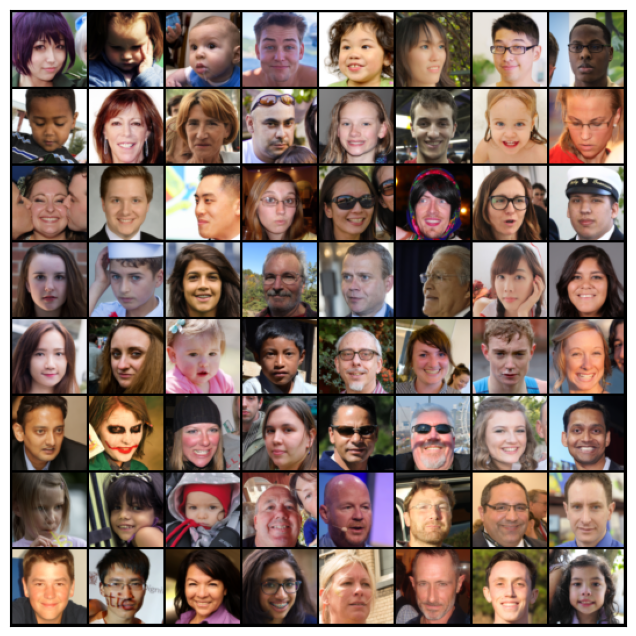

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


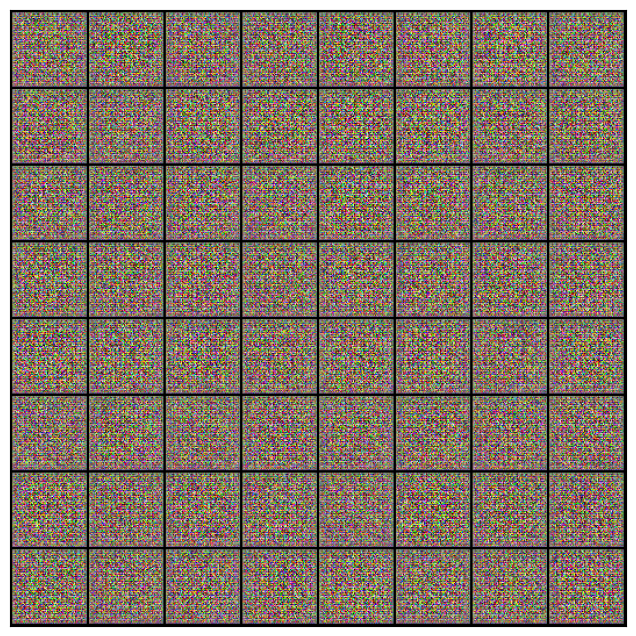

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


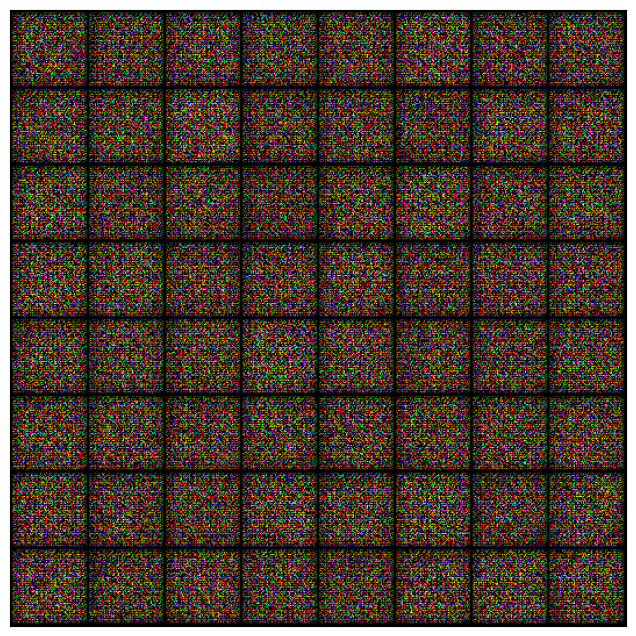

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 3e-4
epochs = 150

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 9.3429, loss_d: 0.1924, real_score: 0.8765, fake_score: 0.0001
Saving generated-images-0001.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 11.7239, loss_d: 0.3774, real_score: 0.8147, fake_score: 0.0000
Saving generated-images-0002.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 5.4343, loss_d: 0.1829, real_score: 0.9177, fake_score: 0.0666
Saving generated-images-0003.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 8.1368, loss_d: 0.2727, real_score: 0.9166, fake_score: 0.1565
Saving generated-images-0004.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 8.1146, loss_d: 0.5725, real_score: 0.6600, fake_score: 0.0017
Saving generated-images-0005.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 3.5794, loss_d: 0.9303, real_score: 0.9102, fake_score: 0.4867
Saving generated-images-0006.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 3.7855, loss_d: 0.6199, real_score: 0.7755, fake_score: 0.2751
Saving generated-images-0007.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.7321, loss_d: 0.6020, real_score: 0.7688, fake_score: 0.2353
Saving generated-images-0008.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.6608, loss_d: 1.0204, real_score: 0.8193, fake_score: 0.4833
Saving generated-images-0009.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 2.7180, loss_d: 0.6981, real_score: 0.6597, fake_score: 0.1322
Saving generated-images-0010.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 2.5176, loss_d: 0.6469, real_score: 0.6622, fake_score: 0.1155
Saving generated-images-0011.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 4.3370, loss_d: 0.3248, real_score: 0.7803, fake_score: 0.0337
Saving generated-images-0012.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 3.4608, loss_d: 0.2923, real_score: 0.8441, fake_score: 0.0964
Saving generated-images-0013.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.0402, loss_d: 0.3255, real_score: 0.8008, fake_score: 0.0592
Saving generated-images-0014.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.3195, loss_d: 0.3997, real_score: 0.7662, fake_score: 0.0850
Saving generated-images-0015.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.0130, loss_d: 0.4641, real_score: 0.7366, fake_score: 0.0985
Saving generated-images-0016.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 1.7088, loss_d: 0.4393, real_score: 0.8191, fake_score: 0.1734
Saving generated-images-0017.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 3.1641, loss_d: 0.5788, real_score: 0.7277, fake_score: 0.1791
Saving generated-images-0018.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.5747, loss_d: 0.7820, real_score: 0.8040, fake_score: 0.3846
Saving generated-images-0019.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 4.8241, loss_d: 1.1271, real_score: 0.9031, fake_score: 0.5785
Saving generated-images-0020.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 1.7225, loss_d: 1.1905, real_score: 0.4532, fake_score: 0.1866
Saving generated-images-0021.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.2720, loss_d: 0.6697, real_score: 0.6497, fake_score: 0.0510
Saving generated-images-0022.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 1.8888, loss_d: 0.6330, real_score: 0.6894, fake_score: 0.1589
Saving generated-images-0023.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 6.2291, loss_d: 1.2496, real_score: 0.8824, fake_score: 0.6011
Saving generated-images-0024.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.2370, loss_d: 0.6846, real_score: 0.6359, fake_score: 0.0939
Saving generated-images-0025.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 5.5179, loss_d: 1.2774, real_score: 0.9389, fake_score: 0.6409
Saving generated-images-0026.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 2.9879, loss_d: 0.8085, real_score: 0.6704, fake_score: 0.2444
Saving generated-images-0027.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 5.5028, loss_d: 0.8861, real_score: 0.8605, fake_score: 0.4712
Saving generated-images-0028.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.6135, loss_d: 0.7732, real_score: 0.7260, fake_score: 0.3023
Saving generated-images-0029.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.5057, loss_d: 0.7565, real_score: 0.6888, fake_score: 0.2413
Saving generated-images-0030.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.4441, loss_d: 0.7753, real_score: 0.8841, fake_score: 0.4297
Saving generated-images-0031.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.0498, loss_d: 0.5222, real_score: 0.7211, fake_score: 0.1336
Saving generated-images-0032.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 5.0313, loss_d: 0.8071, real_score: 0.8296, fake_score: 0.4064
Saving generated-images-0033.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 5.2000, loss_d: 1.0901, real_score: 0.9443, fake_score: 0.5877
Saving generated-images-0034.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 2.3932, loss_d: 0.6489, real_score: 0.6465, fake_score: 0.0910
Saving generated-images-0035.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 4.6433, loss_d: 0.6853, real_score: 0.8513, fake_score: 0.3591
Saving generated-images-0036.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.8946, loss_d: 0.6198, real_score: 0.8650, fake_score: 0.3436
Saving generated-images-0037.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 2.8000, loss_d: 0.5236, real_score: 0.7377, fake_score: 0.1394
Saving generated-images-0038.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 6.1608, loss_d: 0.9917, real_score: 0.9418, fake_score: 0.5506
Saving generated-images-0039.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.1861, loss_d: 0.6238, real_score: 0.9138, fake_score: 0.3798
Saving generated-images-0040.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.0311, loss_d: 0.6198, real_score: 0.7676, fake_score: 0.2511
Saving generated-images-0041.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 2.8037, loss_d: 0.5441, real_score: 0.7022, fake_score: 0.1272
Saving generated-images-0042.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 2.4618, loss_d: 1.0873, real_score: 0.4236, fake_score: 0.0555
Saving generated-images-0043.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 5.1173, loss_d: 0.8014, real_score: 0.8775, fake_score: 0.4436
Saving generated-images-0044.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 4.1318, loss_d: 0.4544, real_score: 0.9051, fake_score: 0.2649
Saving generated-images-0045.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 3.1298, loss_d: 0.9921, real_score: 0.4480, fake_score: 0.0158
Saving generated-images-0046.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 3.3090, loss_d: 0.5292, real_score: 0.7228, fake_score: 0.1203
Saving generated-images-0047.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.8428, loss_d: 0.7446, real_score: 0.8423, fake_score: 0.3877
Saving generated-images-0048.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 6.5606, loss_d: 1.3330, real_score: 0.9695, fake_score: 0.6759
Saving generated-images-0049.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.2988, loss_d: 0.7271, real_score: 0.9010, fake_score: 0.4109
Saving generated-images-0050.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.0650, loss_d: 1.0335, real_score: 0.4317, fake_score: 0.0172
Saving generated-images-0051.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.9832, loss_d: 0.4995, real_score: 0.8986, fake_score: 0.2897
Saving generated-images-0052.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.3351, loss_d: 0.9752, real_score: 0.8302, fake_score: 0.4884
Saving generated-images-0053.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.7487, loss_d: 0.6181, real_score: 0.6328, fake_score: 0.0844
Saving generated-images-0054.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 7.3585, loss_d: 1.1085, real_score: 0.9695, fake_score: 0.6333
Saving generated-images-0055.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 2.8395, loss_d: 0.3695, real_score: 0.8090, fake_score: 0.1215
Saving generated-images-0056.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.1164, loss_d: 0.4108, real_score: 0.7966, fake_score: 0.1300
Saving generated-images-0057.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.0484, loss_d: 0.5301, real_score: 0.7097, fake_score: 0.1244
Saving generated-images-0058.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.5772, loss_d: 0.5613, real_score: 0.8639, fake_score: 0.3034
Saving generated-images-0059.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 1.6047, loss_d: 0.6306, real_score: 0.6247, fake_score: 0.0859
Saving generated-images-0060.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 2.7061, loss_d: 0.6882, real_score: 0.6061, fake_score: 0.0520
Saving generated-images-0061.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.9625, loss_d: 0.5243, real_score: 0.8635, fake_score: 0.2869
Saving generated-images-0062.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 2.2088, loss_d: 0.6727, real_score: 0.6035, fake_score: 0.0870
Saving generated-images-0063.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 3.8093, loss_d: 0.4740, real_score: 0.7465, fake_score: 0.1136
Saving generated-images-0064.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 5.8276, loss_d: 0.6875, real_score: 0.8780, fake_score: 0.3875
Saving generated-images-0065.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.1028, loss_d: 0.5843, real_score: 0.6477, fake_score: 0.0483
Saving generated-images-0066.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 6.1299, loss_d: 0.6503, real_score: 0.9621, fake_score: 0.3979
Saving generated-images-0067.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.9050, loss_d: 0.4920, real_score: 0.8176, fake_score: 0.2184
Saving generated-images-0068.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.8511, loss_d: 0.6960, real_score: 0.7448, fake_score: 0.2674
Saving generated-images-0069.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 1.2943, loss_d: 1.6499, real_score: 0.2548, fake_score: 0.0076
Saving generated-images-0070.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.7391, loss_d: 0.5738, real_score: 0.7881, fake_score: 0.2352
Saving generated-images-0071.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.2991, loss_d: 0.5521, real_score: 0.9033, fake_score: 0.3137
Saving generated-images-0072.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 5.4343, loss_d: 0.4949, real_score: 0.9255, fake_score: 0.3144
Saving generated-images-0073.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 4.2640, loss_d: 0.3641, real_score: 0.9084, fake_score: 0.2068
Saving generated-images-0074.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.2976, loss_d: 0.2563, real_score: 0.8527, fake_score: 0.0682
Saving generated-images-0075.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.8372, loss_d: 0.8037, real_score: 0.5194, fake_score: 0.0261
Saving generated-images-0076.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.6979, loss_d: 0.5632, real_score: 0.8368, fake_score: 0.2762
Saving generated-images-0077.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.1678, loss_d: 0.3588, real_score: 0.9107, fake_score: 0.2104
Saving generated-images-0078.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 6.4577, loss_d: 0.5661, real_score: 0.9536, fake_score: 0.3685
Saving generated-images-0079.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.6086, loss_d: 0.3019, real_score: 0.8990, fake_score: 0.1564
Saving generated-images-0080.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.3050, loss_d: 0.4388, real_score: 0.7323, fake_score: 0.0749
Saving generated-images-0081.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.7397, loss_d: 0.3824, real_score: 0.8820, fake_score: 0.2065
Saving generated-images-0082.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.1899, loss_d: 0.6439, real_score: 0.6185, fake_score: 0.0679
Saving generated-images-0083.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 4.0059, loss_d: 0.4610, real_score: 0.8118, fake_score: 0.1851
Saving generated-images-0084.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 2.8061, loss_d: 0.5161, real_score: 0.6944, fake_score: 0.0908
Saving generated-images-0085.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 2.8476, loss_d: 0.4202, real_score: 0.8242, fake_score: 0.1721
Saving generated-images-0086.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 0.6066, loss_d: 0.8654, real_score: 0.5052, fake_score: 0.0157
Saving generated-images-0087.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 3.0510, loss_d: 0.7057, real_score: 0.5646, fake_score: 0.0241
Saving generated-images-0088.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 1.8036, loss_d: 0.6005, real_score: 0.6236, fake_score: 0.0467
Saving generated-images-0089.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 3.6531, loss_d: 0.3364, real_score: 0.8746, fake_score: 0.1627
Saving generated-images-0090.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 1.6996, loss_d: 0.8280, real_score: 0.4893, fake_score: 0.0157
Saving generated-images-0091.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.3771, loss_d: 0.3844, real_score: 0.9236, fake_score: 0.2291
Saving generated-images-0092.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.1838, loss_d: 0.4493, real_score: 0.9143, fake_score: 0.2750
Saving generated-images-0093.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 3.1252, loss_d: 0.5846, real_score: 0.6868, fake_score: 0.1343
Saving generated-images-0094.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 2.9459, loss_d: 0.3616, real_score: 0.7810, fake_score: 0.0858
Saving generated-images-0095.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.6604, loss_d: 0.3429, real_score: 0.8356, fake_score: 0.1247
Saving generated-images-0096.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 7.3454, loss_d: 0.7934, real_score: 0.9813, fake_score: 0.4910
Saving generated-images-0097.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 3.3597, loss_d: 0.2835, real_score: 0.8059, fake_score: 0.0457
Saving generated-images-0098.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 1.3158, loss_d: 0.8228, real_score: 0.5192, fake_score: 0.0218
Saving generated-images-0099.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.3265, loss_d: 0.6693, real_score: 0.9385, fake_score: 0.4005
Saving generated-images-0100.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

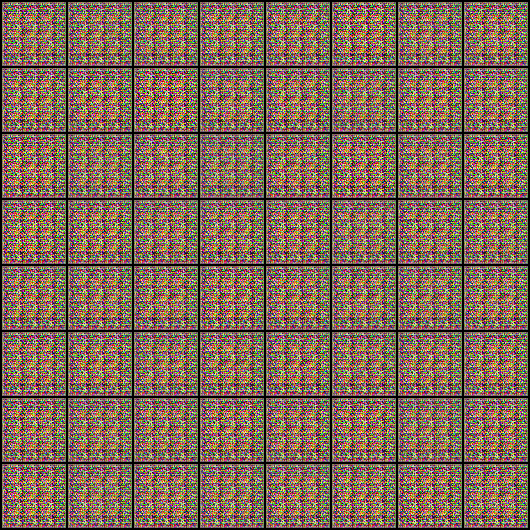

In [ ]:
Image('./generated/generated-images-0001.png')

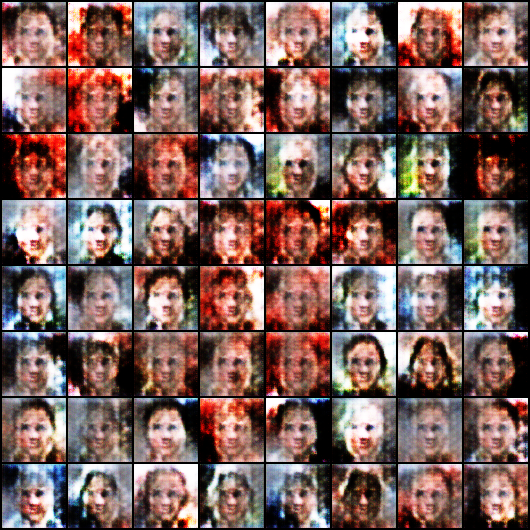

In [ ]:
Image('./generated/generated-images-0025.png')

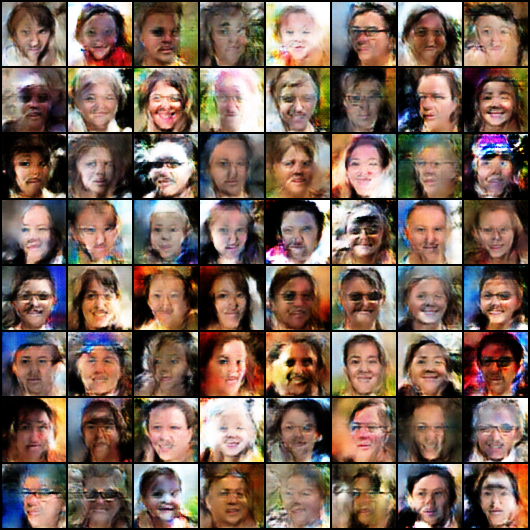

In [ ]:
Image('./generated/generated-images-0100.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

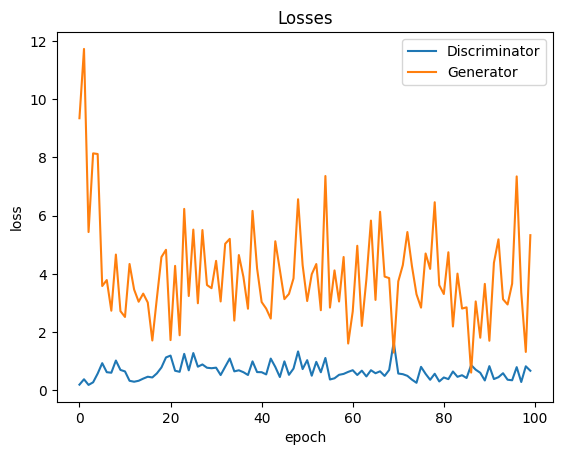

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');